In [1]:
data_dir = r"dataset\Train"


In [2]:
import os
from collections import Counter


# Count total images and per class
total_images = 0
class_counts = {}

for emotion in os.listdir(data_dir):
    class_path = os.path.join(data_dir, emotion)
    if os.path.isdir(class_path):
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[emotion] = len(files)
        total_images += len(files)

print("Class distribution:")
for k, v in class_counts.items():
    print(f"{k}: {v} images")

print(f"\n Total images: {total_images}")


Class distribution:
anger: 1500 images
contempt: 1559 images
disgust: 1229 images
fear: 1512 images
happy: 2340 images
neutral: 2758 images
sad: 3091 images
surprise: 2119 images

 Total images: 16108


In [3]:
import cv2
import numpy as np

# Pick a sample image path
sample_emotion = next(iter(class_counts))
sample_path = os.path.join(data_dir, sample_emotion, os.listdir(os.path.join(data_dir, sample_emotion))[0])

# Load image using OpenCV
img = cv2.imread(sample_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(f"Sample image shape: {img_rgb.shape}")  # (Height, Width, Channels)


Sample image shape: (96, 96, 3)


In [4]:
import os
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [5]:
train_dir = r"dataset\Train"

In [6]:
# Get label distribution from folder structure
classes = sorted(os.listdir(train_dir))
label_list = []

for idx, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        num_files = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        label_list += [idx] * num_files  # use index instead of string class

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(label_list),
    y=label_list
)

class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.3423333333333334), 1: np.float64(1.2915330339961513), 2: np.float64(1.6383238405207485), 3: np.float64(1.3316798941798942), 4: np.float64(0.8604700854700855), 5: np.float64(0.7300580130529369), 6: np.float64(0.6514073115496603), 7: np.float64(0.9502123643227938)}


In [7]:
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.15
)
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 13696 images belonging to 8 classes.
Found 2412 images belonging to 8 classes.


In [8]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True  # freeze for transfer learning

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    # class_weight=class_weights,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
428/428 ━━━━━━━━━━━━━━━━━━━━ 294s 500ms/step - accuracy: 0.1387 - loss: 2.1585 - val_accuracy: 0.1405 - val_loss: 2.0874
Epoch 2/15
428/428 ━━━━━━━━━━━━━━━━━━━━ 201s 469ms/step - accuracy: 0.2163 - loss: 2.0095 - val_accuracy: 0.1932 - val_loss: 2.0303
Epoch 3/15
428/428 ━━━━━━━━━━━━━━━━━━━━ 203s 475ms/step - accuracy: 0.2847 - loss: 1.8526 - val_accuracy: 0.3698 - val_loss: 1.6810
Epoch 4/15
428/428 ━━━━━━━━━━━━━━━━━━━━ 202s 472ms/step - accuracy: 0.3308 - loss: 1.6763 - val_accuracy: 0.3541 - val_loss: 1.7276
Epoch 5/15
428/428 ━━━━━━━━━━━━━━━━━━━━ 262s 472ms/step - accuracy: 0.3782 - loss: 1.5536 - val_accuracy: 0.4677 - val_loss: 1.3721
Epoch 6/15
428/428 ━━━━━━━━━━━━━━━━━━━━ 200s 468ms/step - accuracy: 0.4098 - loss: 1.4747 - val_accuracy: 0.3031 - val_loss: 1.7452
Epoch 7/15
428/428 ━━━━━━━━━━━━━━━━━━━━ 201s 469ms/step - accuracy: 0.4357 - loss: 1.4201 - val_accuracy: 0.4768 - val_loss: 1.3809
Epoch 8/15
428/428 ━━━━━━━━━━━━━━━━━━━━ 201s 469ms/step - accuracy: 0.4651 -

In [ ]:
model_save_path = "emotion_model.h5"


In [21]:
model.save(model_save_path)
print("Model saved to Drive")


Model saved to Drive


76/76 ━━━━━━━━━━━━━━━━━━━━ 39s 431ms/step


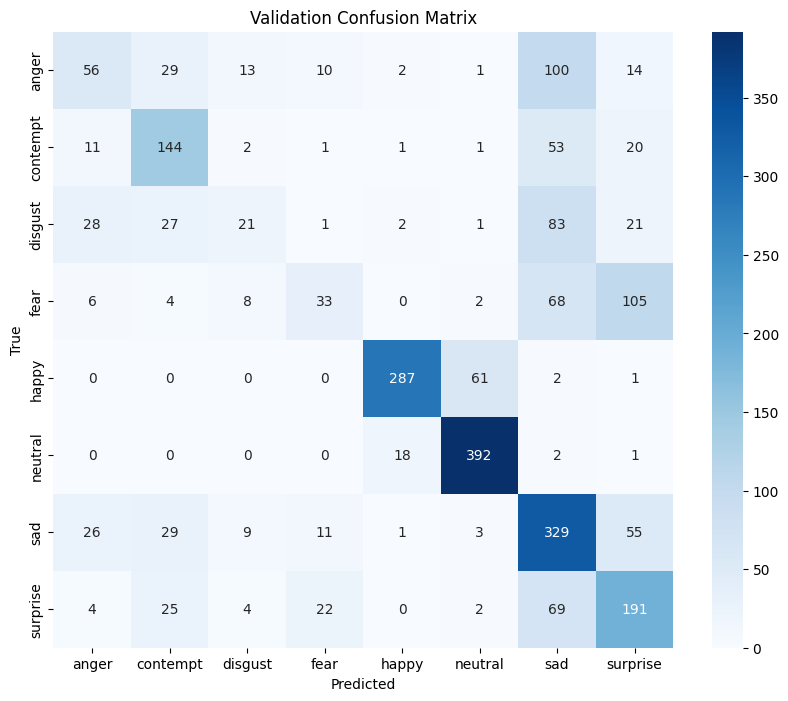

Validation Classification Report:

              precision    recall  f1-score   support

       anger       0.43      0.25      0.31       225
    contempt       0.56      0.62      0.59       233
     disgust       0.37      0.11      0.17       184
        fear       0.42      0.15      0.22       226
       happy       0.92      0.82      0.87       351
     neutral       0.85      0.95      0.89       413
         sad       0.47      0.71      0.56       463
    surprise       0.47      0.60      0.53       317

    accuracy                           0.60      2412
   macro avg       0.56      0.53      0.52      2412
weighted avg       0.59      0.60      0.58      2412



In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

val_generator.reset()  # Ensure order is correct
y_val_probs = model.predict(val_generator, steps=len(val_generator), verbose=1)
y_val_pred = np.argmax(y_val_probs, axis=1)

y_val_true = val_generator.classes
val_class_names = list(val_generator.class_indices.keys())

cm_val = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_class_names, yticklabels=val_class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()

# Optional classification report
print("Validation Classification Report:\n")
print(classification_report(y_val_true, y_val_pred, target_names=val_class_names))


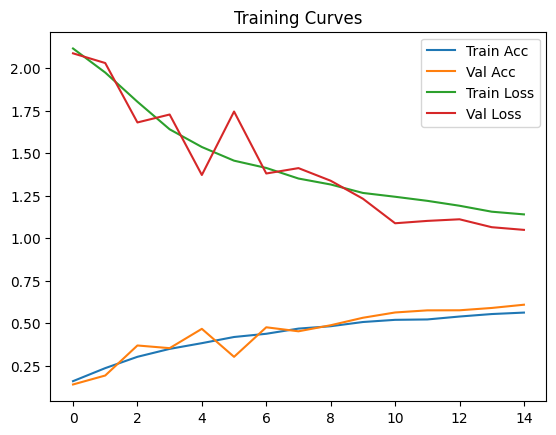

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Curves")
plt.show()


In [9]:
from tensorflow.keras.models import load_model

model = load_model("emotion_model.h5")

In [10]:
emotion_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [11]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """
    Loads an image from the given path and preprocesses it for prediction.

    Parameters:
    - img_path (str): Path to the image file
    - target_size (tuple): Desired image size (width, height)

    Returns:
    - numpy.ndarray: Preprocessed image ready for model prediction
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


In [12]:
print(train_generator.class_indices)

{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}


In [14]:
img_path = r"dataset\Test\neutral\ffhq_1.png"
img_array = load_and_preprocess_image(img_path)
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_emotion = emotion_labels[predicted_class_index]

print(f"Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Emotion: neutral


In [15]:
img_path = r"dataset\Test\Anger\image0002049.jpg"
img_array = load_and_preprocess_image(img_path)
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_emotion = emotion_labels[predicted_class_index]

print(f"Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Predicted Emotion: contempt


In [16]:
img_path = r"dataset\Test\happy\ffhq_10.png"
img_array = load_and_preprocess_image(img_path)
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_emotion = emotion_labels[predicted_class_index]

print(f"Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Predicted Emotion: happy


In [18]:
img_path = r"dataset\Test\surprise\ffhq_387.png"
img_array = load_and_preprocess_image(img_path)
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_emotion = emotion_labels[predicted_class_index]

print(f"Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted Emotion: neutral


In [33]:
img_path = r"D:\ML Team Delta\M4\archive (3)\Train\disgust\image0042542.jpg"
img_array = load_and_preprocess_image(img_path)
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_emotion = emotion_labels[predicted_class_index]

print(f"Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Predicted Emotion: surprise


In [19]:
img_path = r"dataset\Test\disgust\ffhq_7.png"
img_array = load_and_preprocess_image(img_path)
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_emotion = emotion_labels[predicted_class_index]

print(f"Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Predicted Emotion: anger


In [22]:
img_path = r"dataset\Test\Anger\image0020933.jpg"
img_array = load_and_preprocess_image(img_path)
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_emotion = emotion_labels[predicted_class_index]

print(f"Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Predicted Emotion: anger


In [27]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions)

print("Predicted class index:", predicted_class)
print("Confidence:", round(confidence * 100, 2), "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted class index: 4
Confidence: 99.19 %


In [23]:
import os

train_path = r'dataset\Train'
classes = sorted(os.listdir(train_path))
print("Class Labels Order:", classes)


Class Labels Order: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [2]:
!pip install pygame


   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 262.6 kB/s eta 0:00:41
   ---------------------------------------- 0.1/10.6 MB 328.2 kB/s eta 0:00:33
    --------------------------------------- 0.1/10.6 MB 563.7 kB/s eta 0:00:19
    --------------------------------------- 0.2/10.6 MB 772.8 kB/s eta 0:00:14
    --------------------------------------- 0.3/10.6 MB 874.6 kB/s eta 0:00:12
   - -------------------------------------- 0.3/10.6 MB 770.1 kB/s eta 0:00:14
   - -------------------------------------- 0.4/10.6 MB 945.2 kB/s eta 0:00:11
   - -------------------------------------- 0.4/10.6 MB 958.4 kB/s eta 0:00:11
   - -------------------------------------- 0.5/10.6 MB 983.0 kB/s eta 0:00:11
   -- ---


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\AIO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
!pip install playsound


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7044 sha256=d70ceecc76c44fa3c2f62bfb9ea9593064cafb672bfae9a1d11817dbd6cf414c
  Stored in directory: c:\users\aio\appdata\local\pip\cache\wheels\50\98\42\62753a9e1fb97579a0ce2f84f7db4c21c09d03bb2091e6cef4
Successfully built playsound



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\AIO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import os
import random
import numpy as np
import tkinter as tk
from tkinter import messagebox
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pygame

def get_emotion_genre_tracks(image_path, model_path="emotion_model.h5", music_folder=r"D:\ML Team Delta\M4\Data\genres_original", limit=10):
    model = load_model(model_path)

    class_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    expression_to_genres = {
        "anger": ["rock", "metal"],
        "contempt": ["classical", "jazz"],
        "disgust": ["metal", "rock"],
        "fear": ["classical"],
        "happy": ["pop", "disco"],
        "neutral": ["hip-hop", "reggae"],
        "sad": ["blues", "jazz"],
        "surprise": ["pop", "disco"]
    }

    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = img_array.astype("float32") / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        preds = model.predict(img_array)[0]
        label = class_labels[np.argmax(preds)]
        genres = expression_to_genres.get(label, [])
        result = {}
        for genre in genres:
            genre_path = os.path.join(music_folder, genre)
            if not os.path.exists(genre_path):
                result[genre] = []
                continue
            tracks = [file for file in os.listdir(genre_path) if file.lower().endswith(".wav")]
            random.shuffle(tracks)
            result[genre] = [os.path.join(genre_path, track) for track in tracks[:limit]]
        return label, result
    except Exception as e:
        return None, str(e)

def play_music(track_path):
    try:
        pygame.mixer.music.load(track_path)
        pygame.mixer.music.play()
    except Exception as e:
        messagebox.showerror("Error", f"Could not play track:\n{e}")

def stop_music():
    pygame.mixer.music.stop()

# Load image and get emotion + tracks
image_path = r"dataset\Test\happy\ffhq_0.png"
emotion, genre_tracks = get_emotion_genre_tracks(image_path)

# Initialize audio
pygame.init()
pygame.mixer.init()

# Build GUI
root = tk.Tk()
root.title("Emotion Music Recommender")
root.geometry("650x800")
root.configure(bg="#f4f4f4")

tk.Label(root, text=f"Detected Emotion: {emotion}", font=("Arial", 18, "bold"), bg="#f4f4f4").pack(pady=10)

for genre, tracks in genre_tracks.items():
    if not tracks:
        continue
    tk.Label(root, text=f"{genre.upper()} Tracks:", font=("Arial", 14, "bold"), bg="#f4f4f4").pack(pady=(15, 5))
    for track_path in tracks:
        frame = tk.Frame(root, bg="#f4f4f4")
        frame.pack(pady=2, fill="x", padx=10)
        track_name = os.path.basename(track_path)
        tk.Label(frame, text=track_name, font=("Arial", 10), bg="#f4f4f4", anchor="w", width=50).pack(side="left")
        tk.Button(frame, text="▶️ Play", command=lambda t=track_path: play_music(t)).pack(side="right", padx=5)
        tk.Button(frame, text="⏹️ Stop", command=stop_music).pack(side="right")

root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
import os
import random
import numpy as np
import tkinter as tk
from tkinter import messagebox
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import pygame
import cv2

def capture_face_from_camera():
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        raise Exception("Could not open webcam")

    print("Press 's' to capture face image")
    while True:
        ret, frame = cap.read()
        if not ret:
            continue

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        cv2.imshow("Face Capture (press 's')", frame)

        key = cv2.waitKey(1)
        if key == ord('s') and len(faces) > 0:
            x, y, w, h = faces[0]
            face_img = frame[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (224, 224))
            cap.release()
            cv2.destroyAllWindows()
            return face_img

def get_emotion_genre_tracks_from_frame(frame, model_path="emotion_model.h5", music_folder=r"D:\ML Team Delta\M4\Data\genres_original", limit=10):
    model = load_model(model_path)

    class_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    expression_to_genres = {
        "anger": ["rock", "metal"],
        "contempt": ["classical", "jazz"],
        "disgust": ["metal", "rock"],
        "fear": ["classical"],
        "happy": ["pop", "disco"],
        "neutral": ["hip-hop", "reggae"],
        "sad": ["blues", "jazz"],
        "surprise": ["pop", "disco"]
    }

    try:
        img_array = img_to_array(frame)
        img_array = img_array.astype("float32") / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        preds = model.predict(img_array)[0]
        label = class_labels[np.argmax(preds)]

        print("Predicted Emotion:", label)
        genres = expression_to_genres.get(label, [])
        print("Mapped Genres:", genres)

        result = {}
        for genre in genres:
            genre_path = os.path.join(music_folder, genre)
            print("Checking folder:", genre_path)
            if os.path.exists(genre_path):
                files = os.listdir(genre_path)
                print(f"Found {len(files)} files in {genre}: {files[:5]}")
                tracks = [file for file in files if file.lower().endswith(".wav")]
                random.shuffle(tracks)
                result[genre] = [os.path.join(genre_path, track) for track in tracks[:limit]]
            else:
                print(f"Genre folder not found: {genre_path}")
                result[genre] = []
        return label, result
    except Exception as e:
        return None, str(e)

def play_music(track_path):
    try:
        pygame.mixer.music.load(track_path)
        pygame.mixer.music.play()
    except Exception as e:
        messagebox.showerror("Error", f"Could not play track:\n{e}")

def stop_music():
    pygame.mixer.music.stop()

# Run app
frame = capture_face_from_camera()
emotion, genre_tracks = get_emotion_genre_tracks_from_frame(frame)

pygame.init()
pygame.mixer.init()

root = tk.Tk()
root.title("Emotion Music Recommender")
root.geometry("650x800")
root.configure(bg="#f4f4f4")

tk.Label(root, text=f"Detected Emotion: {emotion}", font=("Arial", 18, "bold"), bg="#f4f4f4").pack(pady=10)

for genre, tracks in genre_tracks.items():
    if not tracks:
        continue
    tk.Label(root, text=f"{genre.upper()} Tracks:", font=("Arial", 14, "bold"), bg="#f4f4f4").pack(pady=(15, 5))
    for track_path in tracks:
        frame = tk.Frame(root, bg="#f4f4f4")
        frame.pack(pady=2, fill="x", padx=10)
        track_name = os.path.basename(track_path)
        tk.Label(frame, text=track_name, font=("Arial", 10), bg="#f4f4f4", anchor="w", width=50).pack(side="left")
        tk.Button(frame, text="▶️ Play", command=lambda t=track_path: play_music(t)).pack(side="right", padx=5)
        tk.Button(frame, text="⏹️ Stop", command=stop_music).pack(side="right")

root.mainloop()


Press 's' to capture face image
